In [31]:
import numpy as np
import pandas as pd
from qiskit import Aer, execute, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from qiskit import Aer, execute
from scipy.stats import entropy

In [32]:
# def preprocess_data(filepath):
#     # Load data
#     data = pd.read_csv(filepath, sep='\t', index_col=0)
#     # Binarize data
#     binarized_data = (data > 0).astype(int)
#     # Compute activation ratios
#     activation_ratios = binarized_data.mean(axis=1).values
#     # Compute observed distribution p_obs
#     # Here, we assume each unique combination of gene expressions in cells as a different state
#     labels = binarized_data.apply(lambda row: ''.join(row.astype(str)), axis=0)
#     p_obs = labels.value_counts(normalize=True).reindex([format(i, f'0{len(activation_ratios)}b') for i in range(2**len(activation_ratios))], fill_value=0).values
#     return activation_ratios, p_obs

def preprocess_data(filepath):
    data = pd.read_csv(filepath, sep='\t', index_col=0)
    binarized_data = (data > 0).astype(int)

    # New approach to calculate labels based on gene expression patterns
    labels = [''.join(str(gene) for gene in binarized_data.iloc[:, col]) for col in range(binarized_data.shape[1])]
    unique_labels, counts = np.unique(labels, return_counts=True)
    p_obs = counts / sum(counts)

    # Activation ratios remain the same
    activation_ratios = binarized_data.mean(axis=1).values

    # Return labels for use in plotting, along with activation ratios and p_obs
    return activation_ratios, p_obs, unique_labels

In [33]:
def initialize_theta(n_genes, activation_ratios):
    """Explicit initialization of theta"""
    theta = np.zeros((n_genes, n_genes))
    for k in range(n_genes):
        theta[k, k] = 2 * np.arcsin(np.sqrt(activation_ratios[k]))  # Diagonal initialization
    return theta

In [34]:
def build_qscgrn_circuit(theta):
    n = theta.shape[0]
    qr = QuantumRegister(n)
    cr = ClassicalRegister(n)
    circuit = QuantumCircuit(qr, cr)
    # Apply Ry gates based on activation ratios
    for i in range(n):
        circuit.ry(theta[i, i], qr[i])
    # Apply controlled-RY gates based on theta parameters
    for i in range(n):
        for j in range(i + 1, n):
            circuit.cry(theta[i, j], qr[i], qr[j])
            circuit.cry(theta[j, i], qr[j], qr[i])
    circuit.measure(qr, cr)
    return circuit

In [35]:
def simulate_circuit(circuit):
    backend = Aer.get_backend('qasm_simulator')
    result = execute(circuit, backend, shots=1024).result()
    counts = result.get_counts()
    n_qubits = len(circuit.qubits)
    p_sim = np.zeros(2 ** n_qubits)  # This should match the number of possible states
    for state, count in counts.items():
        state_idx = int(state, 2)  # Convert binary string to integer
        p_sim[state_idx] = count / 1024  # Assign the simulation result
    return p_sim

def compute_kl_divergence(p_obs, p_sim):
    epsilon = 1e-10  # To avoid division by zero
    kl_div = np.sum(np.where(p_obs != 0, p_obs * np.log(p_obs / (p_sim + epsilon)), 0))
    return kl_div

In [36]:
def update_theta(theta, grad, learning_rate=0.05):
    """Update theta by subtracting gradient scaled by learning rate."""
    theta_updated = theta - learning_rate * grad
    # Ensure theta remains within bounds [0, π/2] if necessary
    theta_updated = np.clip(theta_updated, 0, np.pi/2)
    return theta_updated

from qiskit import Aer, execute
from qiskit.circuit import Parameter

def parameter_shift_term(qc, theta, i, j, shift):
    # Copy the original theta array for manipulation
    theta_plus = np.copy(theta)
    theta_minus = np.copy(theta)
    # Apply the parameter shift
    theta_plus[i, j] += shift
    theta_minus[i, j] -= shift
    
    # Construct circuits for the shifted parameters
    qc_plus = build_qscgrn_circuit(theta_plus)
    qc_minus = build_qscgrn_circuit(theta_minus)
    
    # Execute the circuits
    backend = Aer.get_backend('qasm_simulator')
    shots = 1024
    results_plus = execute(qc_plus, backend, shots=shots).result()
    results_minus = execute(qc_minus, backend, shots=shots).result()

    # Calculate probabilities from counts
    counts_plus = results_plus.get_counts(qc_plus)
    counts_minus = results_minus.get_counts(qc_minus)
    # Assuming a binary outcome mapped to {0,1}, we calculate expectation values
    expectation_plus = (counts_plus.get('1', 0) / shots)
    expectation_minus = (counts_minus.get('1', 0) / shots)

    # Return the gradient estimate using the parameter-shift rule
    gradient = (expectation_plus - expectation_minus) / (2 * np.sin(shift))
    return gradient

def compute_gradient(theta, activation_ratios, p_obs, shift=np.pi/2):
    n = len(activation_ratios)
    grad = np.zeros_like(theta)
    for i in range(n):
        for j in range(n):
            # Note: Here we simulate the parameter-shift rule for each parameter theta[i, j]
            grad[i, j] = parameter_shift_term(build_qscgrn_circuit(theta), theta, i, j, shift)
    return grad

In [37]:
def optimize_theta(activation_ratios, p_obs, epochs=50, learning_rate=0.05):
    n = len(activation_ratios)
    theta = initialize_theta(n, activation_ratios)
    for epoch in range(epochs):
        # Construct the circuit based on the current theta
        circuit = build_qscgrn_circuit(theta)
        # Simulate the circuit to get the simulated probability distribution
        p_sim = simulate_circuit(circuit)
        # Compute the loss using the KL divergence between observed and simulated distributions
        loss = compute_kl_divergence(p_obs, p_sim)
        
        # Compute the gradient of the loss function with respect to theta
        grad = compute_gradient(theta, activation_ratios, p_obs)
        
        # Update theta by subtracting the gradient scaled by the learning rate
        theta = update_theta(theta, grad, learning_rate)
        
        # Print out the epoch number and current loss for tracking the optimization process
        print(f'Epoch: {epoch}, Loss: {loss}')
        
    # After the training (optimization) loop, return the optimized theta
    return theta

In [38]:
# def plot_histogram(p_obs, p_sim):
#     plt.figure(figsize=(10, 5))
#     plt.bar(range(len(p_obs)), p_obs, width=0.4, label='Observed', alpha=0.6)
#     plt.bar(np.array(range(len(p_sim))) + 0.4, p_sim, width=0.4, label='Simulated', alpha=0.6)
#     plt.ylabel('Probability')
#     plt.title('Comparison of Observed and Simulated Distributions')
#     plt.legend()
#     plt.show()
    
# Update the plotting function to use labels
def plot_histogram(p_obs, p_sim, labels):
    indices = range(len(p_obs))
    width = 0.35  # Increase the width for thicker bars

    plt.figure(figsize=(20, 5))  # Increase the figure size for a wider histogram
    bars1 = plt.bar(indices, p_obs, width, label='p_obs', alpha=0.6)
    bars2 = plt.bar([p + width for p in indices], p_sim, width, label='p_out', alpha=0.6)

    plt.ylabel('Probability')
    plt.title('Comparison of p_obs and p_out Distributions')
    plt.xticks([r + width for r in range(len(labels))], labels, rotation='vertical')

    # Adding the values on top of each bar
    for bars in (bars1, bars2):
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2.0, yval, f"{yval:.2f}", va='bottom', ha='center', rotation=90)

    plt.legend()
    plt.tight_layout()
    plt.show()
    
    
# def plot_adjacency_matrix(theta):
#     plt.figure(figsize=(8, 6))
#     plt.imshow(theta, cmap='viridis', interpolation='none')
#     plt.colorbar()
#     plt.title('Gene Regulatory Network (GRN) Adjacency Matrix')
#     plt.xlabel('Target Gene')
#     plt.ylabel('Regulatory Gene')
#     plt.show()

In [39]:
def train_model(filepath, epochs=10, learning_rate=0.001):
    # Adjusted to capture unique_labels as well
    activation_ratios, p_obs, labels = preprocess_data(filepath)
    n_genes = len(activation_ratios)
    theta = initialize_theta(n_genes, activation_ratios)
    
    for epoch in range(epochs):
        # Compute simulated probabilities
        circuit = build_qscgrn_circuit(theta)
        p_sim = simulate_circuit(circuit)
        loss = compute_kl_divergence(p_obs, p_sim)
        
        # Compute gradient and update theta
        grad = compute_gradient(theta, activation_ratios, p_obs)
        theta = update_theta(theta, grad, learning_rate)
        
        print(f'Epoch: {epoch}, Loss: {loss}')
    
    # After training, plot the histogram and adjacency matrix
    p_sim = simulate_circuit(build_qscgrn_circuit(theta))
    # Adjusted to pass labels to plot_histogram
    plot_histogram(p_obs, p_sim, labels)
    # plot_adjacency_matrix(theta)

Epoch: 0, Loss: 0.16162777008281806
Epoch: 1, Loss: 0.20948634075787315
Epoch: 2, Loss: 0.275370456055877
Epoch: 3, Loss: 0.25398687376097967
Epoch: 4, Loss: 0.2558787788816429
Epoch: 5, Loss: 0.2227111686621946
Epoch: 6, Loss: 0.24576386618144028
Epoch: 7, Loss: 0.20890505422948202
Epoch: 8, Loss: 0.4585563504810539
Epoch: 9, Loss: 0.214119549113424


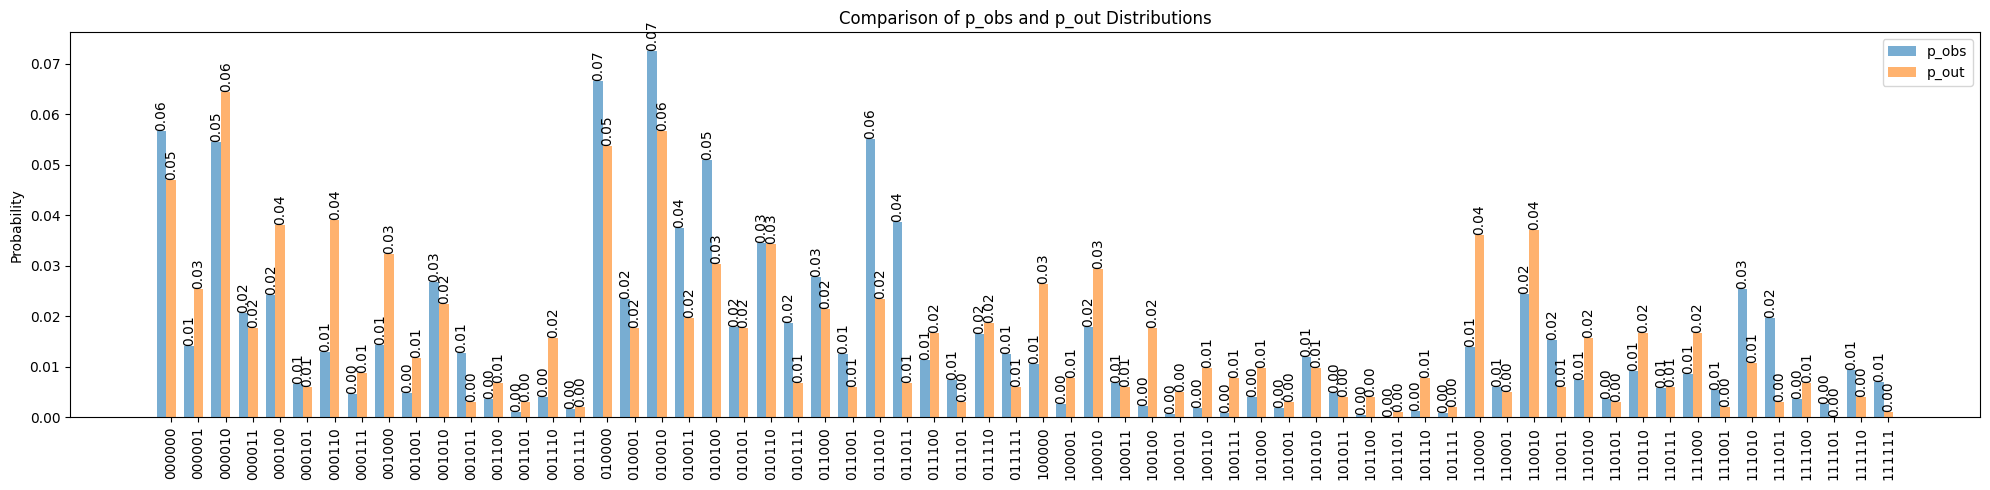

In [40]:
filepath = "/Users/saumyachoudhary/test/dataset/expr_matrix_raw_7.txt"  # Update this to your actual file path
train_model(filepath)